# Attention Head Analysis of DistilBert

In [1]:
!pip install -U transformers datasets nnsight

### Importing the Required libraries

In [2]:
import torch
import torch.nn as nn
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
from datasets import load_dataset
from torch.utils.data import DataLoader, Subset
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
from nnsight import LanguageModel, NNsight

### Data Preprocessing

In [3]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)

In [4]:
dataset = load_dataset('glue', 'sst2')
train_subset_size = 5000
validation_subset_size = 500

# Create subsets
train_indices = list(range(train_subset_size))
validation_indices = list(range(validation_subset_size))


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [5]:
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

def preprocess_function(examples):
    return tokenizer(examples['sentence'], truncation=True, padding='max_length', max_length=128)

# Apply preprocessing to the dataset
encoded_dataset = dataset.map(preprocess_function, batched=True)
encoded_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

In [6]:
# Create subsets using Subset
train_dataset = Subset(encoded_dataset['train'], train_indices)
validation_dataset = Subset(encoded_dataset['validation'], validation_indices)

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=16)
validation_dataloader = DataLoader(validation_dataset, batch_size=16)

In [7]:
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

llm = NNsight(model)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Comptuing Head Importance of heads

In [8]:
def compute_head_importance(llm, dataloader):
    num_layers = model.config.num_hidden_layers
    num_heads = model.config.num_attention_heads
    hidden_dim = model.config.hidden_size
    head_dim = hidden_dim // num_heads
    head_importance = torch.zeros(num_layers, num_heads).to(device)
    total_tokens = 0

    for batch in dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        model.zero_grad()

        with llm.trace(input_ids, attention_mask, labels=labels) as tracer:
            # Access attention outputs
            attention_list = []
            for layer_idx in range(num_layers):
                layer = llm.distilbert.transformer.layer[layer_idx]
                attention = layer.attention.output[0]
                attention.requires_grad_(True)
                attention_list.append(attention)

            loss = llm.output.loss
            loss.backward()

            for layer_idx, attention in enumerate(attention_list):
                grad = attention.grad  # Shape: (batch_size, seq_len, hidden_dim)
                grad = grad.view(grad.size(0), grad.size(1), num_heads, head_dim)
                grad = grad.permute(0, 2, 1, 3)

                # Compute average absolute gradient
                grad = grad.abs().mean(dim=(0, 2, 3))  # Shape: (num_heads,)

                head_importance[layer_idx] += grad.detach()

        total_tokens += input_ids.size(0) * input_ids.size(1)  # Batch size * seq_len

    # Normalize the head importance
    head_importance /= total_tokens
    return head_importance.cpu()

head_importance = compute_head_importance(llm, train_dataloader)

In [9]:
def create_head_mask(heads_to_disable):
    head_mask = torch.ones(num_layers, num_heads)
    for layer, head in heads_to_disable:
        head_mask[layer, head] = 0
    return head_mask.to(device)

def evaluate_with_head_mask(model, dataloader, head_mask):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, head_mask=head_mask)
            predictions = torch.argmax(outputs.logits, dim=-1)
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    return accuracy

def evaluate(model, dataloader):
    return evaluate_with_head_mask(model, dataloader, head_mask=None)

In [10]:
baseline_accuracy = evaluate(model, validation_dataloader)
print(f'Baseline Validation Accuracy: {baseline_accuracy:.4f}')

Baseline Validation Accuracy: 0.4000


### Fine Tuning the Model

In [11]:
num_layers = model.config.n_layers
num_heads = model.config.n_heads
hidden_dim = model.config.dim
head_dim = hidden_dim // num_heads

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

epochs = 5
for epoch in range(epochs):
    model.train()
    for batch in train_dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        loss = outputs.loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

baseline_accuracy = evaluate(model, validation_dataloader)
print(f'Baseline Validation Accuracy after fine tuning: {baseline_accuracy:.4f}')

Baseline Validation Accuracy after fine tuning: 0.8800


### Getting heads from each layer

In [12]:
def get_top_bottom_random_heads(head_importance, K):
    importance = head_importance.view(-1)
    sorted_indices = torch.argsort(importance, descending=True)

    topk_indices = sorted_indices[:K * num_layers]
    bottomk_indices = sorted_indices[-K * num_layers:]

    topk_heads = [(int(idx // num_heads), int(idx % num_heads)) for idx in topk_indices]
    bottomk_heads = [(int(idx // num_heads), int(idx % num_heads)) for idx in bottomk_indices]

    # For random heads
    random_heads = []
    for layer in range(num_layers):
        random_indices = random.sample(range(num_heads), K)
        random_heads.extend([(layer, head) for head in random_indices])

    return topk_heads, bottomk_heads, random_heads


In [13]:
def get_new_model_from_state_dict(state_dict):
    new_model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')
    new_model.load_state_dict(state_dict, strict=True)
    new_model.to(device)
    return new_model

def finetune_with_head_mask(original_model, train_dataloader, head_mask, device, epochs=5):
    # Save original state dict
    state_dict = original_model.state_dict()

    # Initialize a fresh model and load state_dict
    temp_model = get_new_model_from_state_dict(state_dict)
    optimizer = torch.optim.AdamW(temp_model.parameters(), lr=5e-5)

    temp_model.train()
    for epoch in range(epochs):
        for batch in train_dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = temp_model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels,
                head_mask=head_mask
            )
            loss = outputs.loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    return temp_model



### Results of removing heads from each layer

In [14]:
results = {}
results['baseline'] = baseline_accuracy

for K in [2,4]:
    topk_heads, bottomk_heads, random_heads = get_top_bottom_random_heads(head_importance, K)

    head_mask_topk = create_head_mask(topk_heads)
    head_mask_bottomk = create_head_mask(bottomk_heads)
    head_mask_random = create_head_mask(random_heads)

    # Fine-tune after disabling heads
    finetuned_topk_model = finetune_with_head_mask(model, train_dataloader, head_mask_topk, device)
    accuracy_finetuned_topk = evaluate_with_head_mask(finetuned_topk_model, validation_dataloader, head_mask_topk)

    finetuned_bottomk_model = finetune_with_head_mask(model, train_dataloader, head_mask_bottomk, device)
    accuracy_finetuned_bottomk = evaluate_with_head_mask(finetuned_bottomk_model, validation_dataloader, head_mask_bottomk)

    finetuned_random_model = finetune_with_head_mask(model, train_dataloader, head_mask_random, device)
    accuracy_finetuned_random = evaluate_with_head_mask(finetuned_random_model, validation_dataloader, head_mask_random)

    results[(K, 'topk_finetuned')] = accuracy_finetuned_topk
    results[(K, 'bottomk_finetuned')] = accuracy_finetuned_bottomk
    results[(K, 'random_finetuned')] = accuracy_finetuned_random

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
DistilBertSdpaAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You sh

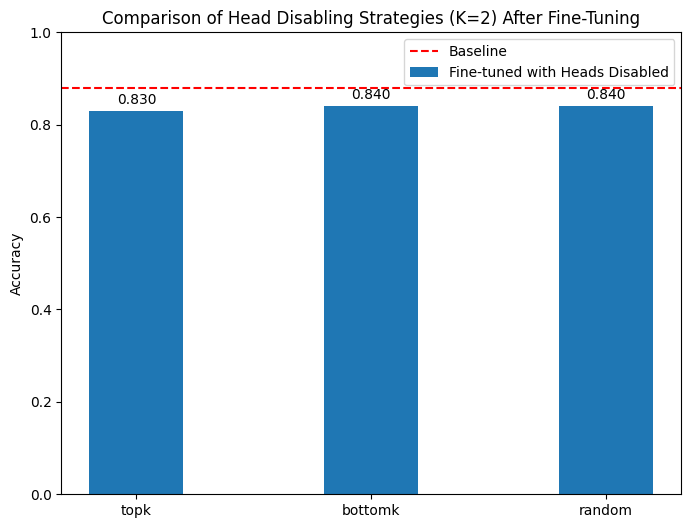

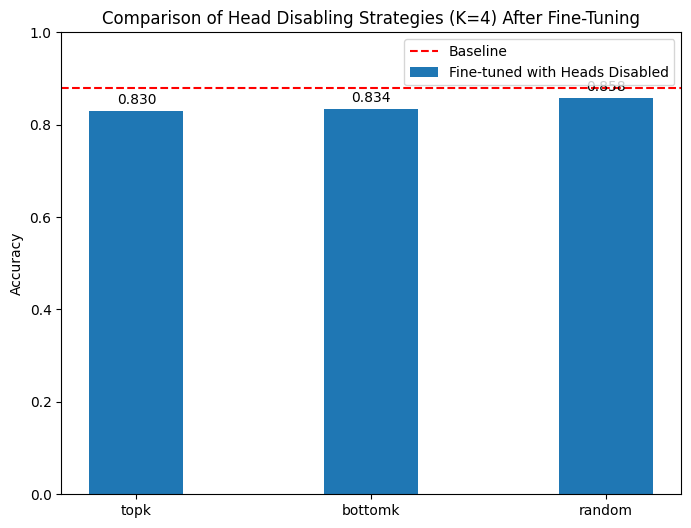

In [15]:
for K in [2,4]:
    conditions = ['topk', 'bottomk', 'random']
    finetuned_acc = [results[(K, c + '_finetuned')] for c in conditions]

    x = np.arange(len(conditions))  # positions for groups
    width = 0.4

    fig, ax = plt.subplots(figsize=(8, 6))
    rects = ax.bar(x, finetuned_acc, width, label='Fine-tuned with Heads Disabled')

    ax.set_ylabel('Accuracy')
    ax.set_title(f'Comparison of Head Disabling Strategies (K={K}) After Fine-Tuning')
    ax.set_xticks(x)
    ax.set_xticklabels(conditions)
    ax.axhline(y=baseline_accuracy, color='r', linestyle='--', label='Baseline')
    ax.legend()

    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.3f}',
                        xy=(rect.get_x() + rect.get_width()/2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom')
    autolabel(rects)

    plt.ylim(0.0, 1.0)
    plt.show()

## Single Headed Attention

In [16]:
class SingleHeadSelfAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.dim = config.dim
        self.n_heads = 1
        self.dropout = config.attention_dropout
        self.dim_per_head = self.dim // self.n_heads
        assert self.dim_per_head * self.n_heads == self.dim, "Hidden size not divisible by number of heads"

        self.q_lin = nn.Linear(self.dim, self.dim)
        self.k_lin = nn.Linear(self.dim, self.dim)
        self.v_lin = nn.Linear(self.dim, self.dim)
        self.out_lin = nn.Linear(self.dim, self.dim)
        self.scale = self.dim_per_head ** -0.5
        self.dropout = nn.Dropout(self.dropout)

    def forward(self, query, key, value, mask, head_mask=None, output_attentions=False):
        batch_size, seq_length, _ = query.size()
        q = self.q_lin(query).view(batch_size, seq_length, self.n_heads, self.dim_per_head).transpose(1, 2)
        k = self.k_lin(key).view(batch_size, seq_length, self.n_heads, self.dim_per_head).transpose(1, 2)
        v = self.v_lin(value).view(batch_size, seq_length, self.n_heads, self.dim_per_head).transpose(1, 2)

        # Scaling
        q = q / (self.dim_per_head ** 0.5)

        scores = torch.matmul(q, k.transpose(-2, -1))  # (batch_size, n_heads, seq_length, seq_length)

        if mask is not None:
            if mask.dim() == 2:
                mask = (mask == 0).unsqueeze(1).unsqueeze(2)  # (batch_size, 1, 1, seq_length)
            elif mask.dim() == 3:
                mask = (mask == 0).unsqueeze(1)  # (batch_size, 1, seq_length, seq_length)
            elif mask.dim() == 4:
                mask = (mask[:, 0, :, :] == 0).unsqueeze(1)  # (batch_size, 1, seq_length, seq_length)


            else: # (batch_size, 1, seq_length, seq_length)
                raise ValueError(f"Unsupported mask shape {mask.shape}")
            scores = scores.masked_fill(mask, -float('inf'))


        attn_weights = torch.softmax(scores, dim=-1)  # (batch_size, n_heads, seq_length, seq_length)
        attn_weights = self.dropout(attn_weights)


        if head_mask is not None:
            attn_weights = attn_weights * head_mask

        context = torch.matmul(attn_weights, v)  # (batch_size, n_heads, seq_length, dim_per_head)
        context = context.transpose(1, 2).contiguous().view(batch_size, seq_length, self.dim)  # (batch_size, seq_length, dim)

        output = self.out_lin(context)

        if output_attentions:
            return output, attn_weights
        else:
            return output, None

# Replace attention modules with single-headed attention
for layer in model.distilbert.transformer.layer:
    layer.attention = SingleHeadSelfAttention(model.config).to(device)

model.to(device)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): SingleHeadSelfAttention(
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


### Results of the single head model

In [17]:
epoch_values = range(1, 6)
single_head_accuracies = []

for e in epoch_values:
    optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
    epochs = 5

    for epoch in range(epochs):
        model.train()
        for batch in train_dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    acc = evaluate(model, validation_dataloader)
    single_head_accuracies.append(acc)
    print(f"Single-Headed Model: Epochs={e}, Accuracy={acc:.4f}")

Single-Headed Model: Epochs=1, Accuracy=0.5300
Single-Headed Model: Epochs=2, Accuracy=0.5300
Single-Headed Model: Epochs=3, Accuracy=0.5300
Single-Headed Model: Epochs=4, Accuracy=0.5300
Single-Headed Model: Epochs=5, Accuracy=0.5300


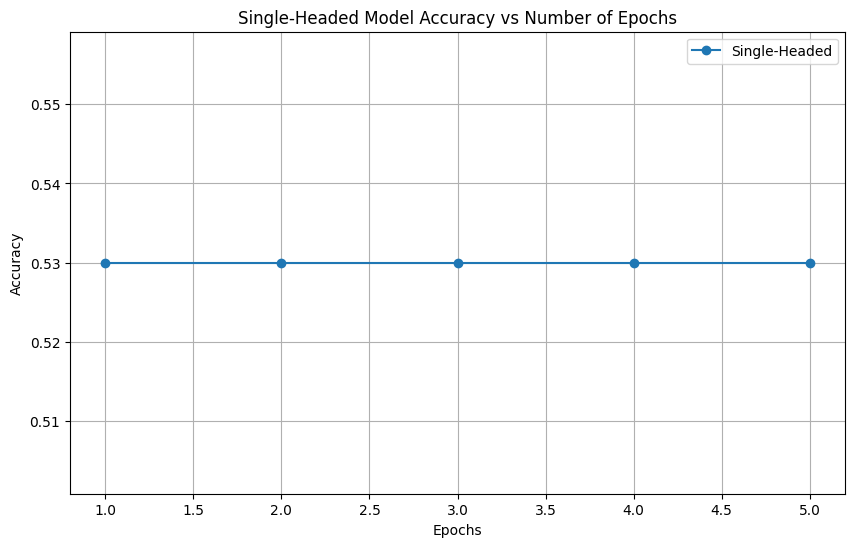

In [18]:
# Plot accuracy vs epochs for the single-headed model
plt.figure(figsize=(10,6))
plt.plot(epoch_values, single_head_accuracies, marker='o', label='Single-Headed')
plt.title('Single-Headed Model Accuracy vs Number of Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()